In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [207]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [208]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Inverse function programming

In [209]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

In [210]:
xx

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [211]:
dt = DistanceTransform(784, 100, p=2)
dt.set_centroid_to_data_randomly(train_loader)
dt.centers.data += torch.randn_like(dt.centers)*0.01
# dt.set_centroid_to_data_maxdist(train_loader)
dt.to(device)

DistanceTransform()

In [212]:
dists = dt(xx.to(device))

In [213]:
dt.compute_inverse_matrix()

In [214]:
dt.inv_params

(tensor([[-0.0007, -0.0014, -0.0008,  ...,  0.0022,  0.0015,  0.0013],
         [ 0.0008,  0.0014,  0.0009,  ...,  0.0002, -0.0002, -0.0002],
         [ 0.0003,  0.0007,  0.0011,  ...,  0.0017,  0.0009,  0.0017],
         ...,
         [ 0.0014,  0.0021,  0.0017,  ...,  0.0007,  0.0010, -0.0002],
         [-0.0022, -0.0039, -0.0046,  ..., -0.0012, -0.0011, -0.0014],
         [ 0.0020,  0.0024,  0.0026,  ..., -0.0040, -0.0030, -0.0024]],
        device='cuda:0', grad_fn=<MmBackward>),
 tensor([[-2.7051e+01],
         [-2.1445e+01],
         [-4.9160e+01],
         [ 8.5014e+00],
         [ 1.4237e+02],
         [-1.2627e+02],
         [ 7.3843e+01],
         [-2.7005e+01],
         [-8.8709e+01],
         [-5.8139e+00],
         [ 1.8690e+02],
         [ 1.4369e+01],
         [-7.3376e+01],
         [ 1.0057e+02],
         [-2.1940e+01],
         [-2.4632e+02],
         [ 1.3328e+02],
         [-1.0815e+02],
         [ 4.1797e+01],
         [ 1.6804e+02],
         [-5.2463e+00],
       

In [215]:
xrec = dt.inverse(dists)

In [216]:
iclose = torch.isclose(xrec.data.cpu(), xx, atol=1e-3)
iclose

tensor([[False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [ True, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False, False, False]])

In [217]:
print("Not close", torch.numel(xx)-torch.count_nonzero(iclose))

Not close tensor(38774)


In [218]:
i=2

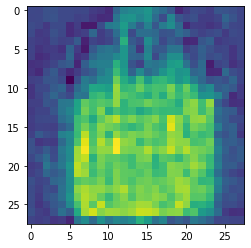

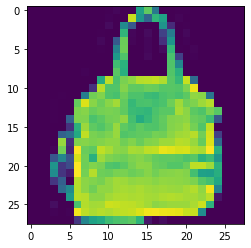

In [219]:
plt.imshow(xrec.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx.data[i].cpu().reshape(28,28))
plt.show()
i+=1

## Train to reduce reconstruction error

In [220]:
dt = DistanceTransform(784, 100)

dt.set_centroid_to_data_randomly(train_loader)
dt.centers.data += torch.randn_like(dt.centers)*0.01
dt.to(device)

DistanceTransform()

In [221]:
indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx_, _ = test_loader.dataset[indices]

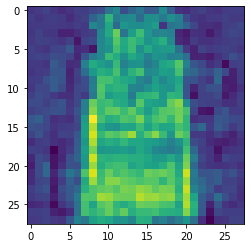

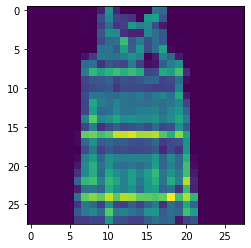

In [222]:
dists = dt(xx_.to(device))
dt.compute_inverse_matrix()
xrec_ = dt.inverse(dists)
i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [223]:
optimizer = optim.Adam(list(dt.parameters()), lr=0.1)
criterion = nn.MSELoss()

In [224]:
index = 0
train_error, test_error = [], []
dt.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        dists = dt(xx)
        dt.compute_inverse_matrix()
        xrec = dt.inverse(dists)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            dists = dt(xx)
            dt.compute_inverse_matrix()
            xrec = dt.inverse(dists)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:08<03:58,  8.23s/it]

Epoch: 0:0, Train Error:0.008491 Test Error:0.008108


  7%|▋         | 2/30 [00:16<03:51,  8.26s/it]

Epoch: 1:0, Train Error:0.008046 Test Error:0.007997


 10%|█         | 3/30 [00:24<03:42,  8.26s/it]

Epoch: 2:0, Train Error:0.007982 Test Error:0.007964


 13%|█▎        | 4/30 [00:33<03:34,  8.27s/it]

Epoch: 3:0, Train Error:0.007951 Test Error:0.007915


 17%|█▋        | 5/30 [00:41<03:26,  8.27s/it]

Epoch: 4:0, Train Error:0.007926 Test Error:0.007911


 20%|██        | 6/30 [00:49<03:18,  8.26s/it]

Epoch: 5:0, Train Error:0.007904 Test Error:0.007894


 23%|██▎       | 7/30 [00:57<03:09,  8.24s/it]

Epoch: 6:0, Train Error:0.007888 Test Error:0.007872


 27%|██▋       | 8/30 [01:06<03:01,  8.26s/it]

Epoch: 7:0, Train Error:0.007875 Test Error:0.007861


 30%|███       | 9/30 [01:14<02:53,  8.27s/it]

Epoch: 8:0, Train Error:0.007861 Test Error:0.007845


 33%|███▎      | 10/30 [01:22<02:45,  8.25s/it]

Epoch: 9:0, Train Error:0.007851 Test Error:0.007841


 37%|███▋      | 11/30 [01:30<02:36,  8.26s/it]

Epoch: 10:0, Train Error:0.007842 Test Error:0.007830


 40%|████      | 12/30 [01:39<02:28,  8.25s/it]

Epoch: 11:0, Train Error:0.007834 Test Error:0.007823


 43%|████▎     | 13/30 [01:47<02:20,  8.25s/it]

Epoch: 12:0, Train Error:0.007828 Test Error:0.007809


 47%|████▋     | 14/30 [01:55<02:12,  8.25s/it]

Epoch: 13:0, Train Error:0.007821 Test Error:0.007816


 50%|█████     | 15/30 [02:03<02:03,  8.24s/it]

Epoch: 14:0, Train Error:0.007816 Test Error:0.007812


 53%|█████▎    | 16/30 [02:11<01:55,  8.22s/it]

Epoch: 15:0, Train Error:0.007811 Test Error:0.007804


 57%|█████▋    | 17/30 [02:20<01:46,  8.23s/it]

Epoch: 16:0, Train Error:0.007807 Test Error:0.007803


 60%|██████    | 18/30 [02:28<01:38,  8.24s/it]

Epoch: 17:0, Train Error:0.007803 Test Error:0.007796


 63%|██████▎   | 19/30 [02:36<01:30,  8.24s/it]

Epoch: 18:0, Train Error:0.007800 Test Error:0.007789


 67%|██████▋   | 20/30 [02:44<01:22,  8.22s/it]

Epoch: 19:0, Train Error:0.007796 Test Error:0.007789


 70%|███████   | 21/30 [02:53<01:14,  8.22s/it]

Epoch: 20:0, Train Error:0.007793 Test Error:0.007787


 73%|███████▎  | 22/30 [03:01<01:05,  8.23s/it]

Epoch: 21:0, Train Error:0.007791 Test Error:0.007785


 77%|███████▋  | 23/30 [03:09<00:57,  8.24s/it]

Epoch: 22:0, Train Error:0.007788 Test Error:0.007782


 80%|████████  | 24/30 [03:17<00:49,  8.24s/it]

Epoch: 23:0, Train Error:0.007786 Test Error:0.007777


 83%|████████▎ | 25/30 [03:26<00:41,  8.25s/it]

Epoch: 24:0, Train Error:0.007784 Test Error:0.007780


 87%|████████▋ | 26/30 [03:34<00:32,  8.24s/it]

Epoch: 25:0, Train Error:0.007782 Test Error:0.007774


 90%|█████████ | 27/30 [03:42<00:24,  8.24s/it]

Epoch: 26:0, Train Error:0.007779 Test Error:0.007778


 93%|█████████▎| 28/30 [03:50<00:16,  8.25s/it]

Epoch: 27:0, Train Error:0.007778 Test Error:0.007773


 97%|█████████▋| 29/30 [03:59<00:08,  8.24s/it]

Epoch: 28:0, Train Error:0.007776 Test Error:0.007773


100%|██████████| 30/30 [04:07<00:00,  8.25s/it]

Epoch: 29:0, Train Error:0.007774 Test Error:0.007770


In [ ]:
### With backprop in inv function
#Epoch: 29:0, Train Error:0.007772 Test Error:0.007768

### Without
#

In [225]:
dists = dt(xx_.to(device))
dt.compute_inverse_matrix()
xrec_2 = dt.inverse(dists)
i=0

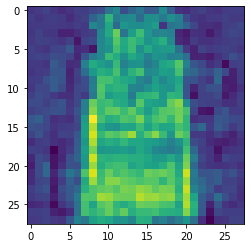

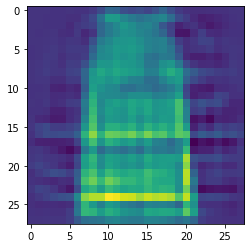

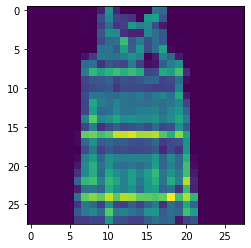

In [226]:
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1

### Train linear autoencoder for comparision

In [227]:
class LinearAE(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.enc = nn.Linear(input_dim, hidden_dim)
        self.bias = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        h = self.enc(x)
        w = self.enc.weight
#         w = torch.pinverse(self.enc.weight.t())

        xrec = torch.matmul(h, w) + self.bias
        return xrec

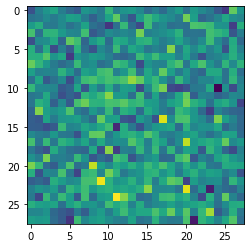

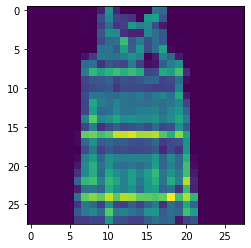

In [228]:
lae = LinearAE(784, 100).to(device)

xrec_ = lae(xx_.to(device)); i=0
plt.imshow(xrec_.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show()

In [229]:
optimizer = optim.Adam(list(lae.parameters()), lr=0.001)
criterion = nn.MSELoss()

In [230]:
index = 0
train_error, test_error = [], []
lae.train()
for epoch in tqdm(list(range(30))):
    train_err = 0
    train_count = 0
    
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        xrec = lae(xx)
        
        loss = criterion(xrec, xx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_err += float(loss)*len(xx)
        train_count += len(xx)

    test_err = 0
    test_count = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            xrec = lae(xx)
            loss = criterion(xrec, xx)
            test_err += float(loss)*len(xx)
            test_count += len(xx)
            
    train_error.append(train_err/train_count)
    test_error.append(test_err/test_count)
        
    print(f'Epoch: {epoch}:{index}, Train Error:{train_error[-1]:4f} Test Error:{test_error[-1]:4f}')

  3%|▎         | 1/30 [00:01<00:53,  1.83s/it]

Epoch: 0:0, Train Error:0.015162 Test Error:0.009113


  7%|▋         | 2/30 [00:03<00:50,  1.80s/it]

Epoch: 1:0, Train Error:0.008481 Test Error:0.008206


 10%|█         | 3/30 [00:05<00:48,  1.80s/it]

Epoch: 2:0, Train Error:0.008103 Test Error:0.008074


 13%|█▎        | 4/30 [00:07<00:46,  1.79s/it]

Epoch: 3:0, Train Error:0.008046 Test Error:0.008021


 17%|█▋        | 5/30 [00:09<00:45,  1.81s/it]

Epoch: 4:0, Train Error:0.008035 Test Error:0.008036


 20%|██        | 6/30 [00:10<00:43,  1.81s/it]

Epoch: 5:0, Train Error:0.008028 Test Error:0.008025


 23%|██▎       | 7/30 [00:12<00:41,  1.79s/it]

Epoch: 6:0, Train Error:0.008025 Test Error:0.008006


 27%|██▋       | 8/30 [00:14<00:39,  1.77s/it]

Epoch: 7:0, Train Error:0.008021 Test Error:0.008005


 30%|███       | 9/30 [00:16<00:37,  1.77s/it]

Epoch: 8:0, Train Error:0.008016 Test Error:0.008029


 33%|███▎      | 10/30 [00:17<00:35,  1.77s/it]

Epoch: 9:0, Train Error:0.008015 Test Error:0.008005


 37%|███▋      | 11/30 [00:19<00:33,  1.78s/it]

Epoch: 10:0, Train Error:0.008012 Test Error:0.008011


 40%|████      | 12/30 [00:21<00:32,  1.79s/it]

Epoch: 11:0, Train Error:0.008008 Test Error:0.008022


 43%|████▎     | 13/30 [00:23<00:30,  1.78s/it]

Epoch: 12:0, Train Error:0.008006 Test Error:0.008000


 47%|████▋     | 14/30 [00:25<00:28,  1.79s/it]

Epoch: 13:0, Train Error:0.008004 Test Error:0.007993


 50%|█████     | 15/30 [00:26<00:26,  1.80s/it]

Epoch: 14:0, Train Error:0.008002 Test Error:0.007986


 53%|█████▎    | 16/30 [00:28<00:25,  1.81s/it]

Epoch: 15:0, Train Error:0.007999 Test Error:0.007995


 57%|█████▋    | 17/30 [00:30<00:23,  1.79s/it]

Epoch: 16:0, Train Error:0.007998 Test Error:0.007977


 60%|██████    | 18/30 [00:32<00:21,  1.79s/it]

Epoch: 17:0, Train Error:0.007996 Test Error:0.007995


 63%|██████▎   | 19/30 [00:34<00:19,  1.79s/it]

Epoch: 18:0, Train Error:0.007993 Test Error:0.007982


 67%|██████▋   | 20/30 [00:35<00:18,  1.81s/it]

Epoch: 19:0, Train Error:0.007991 Test Error:0.007968


 70%|███████   | 21/30 [00:37<00:16,  1.79s/it]

Epoch: 20:0, Train Error:0.007991 Test Error:0.007995


 73%|███████▎  | 22/30 [00:39<00:14,  1.76s/it]

Epoch: 21:0, Train Error:0.007988 Test Error:0.007985


 77%|███████▋  | 23/30 [00:41<00:12,  1.77s/it]

Epoch: 22:0, Train Error:0.007987 Test Error:0.007956


 80%|████████  | 24/30 [00:42<00:10,  1.79s/it]

Epoch: 23:0, Train Error:0.007987 Test Error:0.007972


 83%|████████▎ | 25/30 [00:44<00:08,  1.79s/it]

Epoch: 24:0, Train Error:0.007985 Test Error:0.007972


 87%|████████▋ | 26/30 [00:46<00:07,  1.79s/it]

Epoch: 25:0, Train Error:0.007984 Test Error:0.007964


 90%|█████████ | 27/30 [00:48<00:05,  1.80s/it]

Epoch: 26:0, Train Error:0.007982 Test Error:0.007977


 93%|█████████▎| 28/30 [00:50<00:03,  1.80s/it]

Epoch: 27:0, Train Error:0.007982 Test Error:0.007975


 97%|█████████▋| 29/30 [00:51<00:01,  1.81s/it]

Epoch: 28:0, Train Error:0.007980 Test Error:0.007976


100%|██████████| 30/30 [00:53<00:00,  1.79s/it]

Epoch: 29:0, Train Error:0.007979 Test Error:0.007970


In [231]:
xrec_3 = lae(xx_.to(device))
i=0

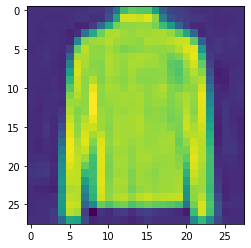

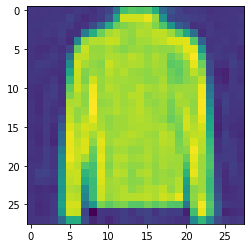

In [ ]:
plt.imshow(xrec_2.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xrec_3.data[i].cpu().reshape(28,28))
plt.show()
plt.imshow(xx_.data[i].cpu().reshape(28,28))
plt.show(); i+=1